In [37]:
%matplotlib inline
import matplotlib.pyplot as plt

import abc
import collections
import math
import random

import numpy as np
import scipy.sparse as sp

In [2]:
class PhysicalModel(metaclass=abc.ABCMeta):        
    @abc.abstractmethod
    def get_energy(self):
        pass
    
    @abc.abstractmethod
    def get_state(self):
        pass
    
    @abc.abstractmethod
    def update(self):
        pass
    
    @property
    def energy(self):
        return self.get_energy()
    
    @property
    def state(self):
        return self.get_state()

In [240]:
class IsingModel(PhysicalModel):
    def __init__(self, lattice_shape, j, h=None, beta=40, neighbor_size=2):
        """Class of Ising model.

        Arguments:
            lattice_shape (tuple): Shape of lattice.
            j (dict): Interaction strength.
            h (np.ndarray): external field strength.
            beta (float): inverse temperature.
            neighbor_size (int): Size of neighbors.
        """
        super().__init__()
        
        self.lattice_shape = lattice_shape
        self.lattice_size = np.prod(lattice_shape)
        self.j = j
        self.h = h
        self.beta = beta
        self.neighbor_size = neighbor_size

        # J for flatten state
        self._flat_j = sp.dok_matrix((self.lattice_size, self.lattice_size))
        for k, v in j.items():
            x = np.ravel_multi_index(k[len(k)//2:], lattice_shape)
            y = np.ravel_multi_index(k[:len(k)//2], lattice_shape)
            self._flat_j[x, y] = self._flat_j[y, x] = v  # j must be symmetric.
            
        # H for flatten state
        self._flat_h = np.zeros(self.lattice_size)
        if h is not None:
            assert h.shape == lattice_shape
            self._flat_h = h.flatten()

        self._state = self.generate_initial_state()

    def generate_initial_state(self):
        return np.random.randint(2, size=self.lattice_shape)*2 - 1

    def get_state(self):
        return self._state

    def get_energy(self):
        flatten = self._state.ravel()
        e = flatten.T.dot(self._flat_j.dot(flatten))
        e += self._flat_h.dot(flatten) if self.h is not None else 0.
        return e

    def update(self):
        assert hasattr(self, 'beta')
        
        current_energy = self.get_energy()
        num_flip = np.random.randint(self.neighbor_size) + 1
        indices = np.random.choice(
            range(self.lattice_size),
            num_flip,
            replace=False
        )

        self._flip_spins(indices)

        candidate_energy = self.get_energy()
        delta = max(0.0, candidate_energy - current_energy)

        if math.exp(-self.beta*delta) >= random.random():
            return True
        else:
            # revert flipped spins
            self._flip_spins(indices)
            return False

    def _flip_spins(self, flatten_indices):
        for idx in flatten_indices:
            value = self.state.take(idx)
            self.state.put(idx, -value)
        return self.state

In [4]:
class QuantumIsingModel(IsingModel):
    def __init__(self, lattice_shape, j, h=None, beta=1., gamma=10.0, n_trotter=32, neighbor_size=2):
        self.gamma = gamma
        self.n_trotter = n_trotter
        super().__init__(lattice_shape, j, h, beta, neighbor_size)
        
    def generate_initial_state(self):
        _super = super()
        return np.array([_super.generate_initial_state() for _ in range(self.n_trotter)])
    
    @property
    def classical_state(self):
        return self.get_best_layer()
    
    def get_best_layer(self):
        min_energy = np.inf
        best_layer = None
        flatten = self._state.reshape((-1, self.n_trotter))
        for i in range(self.n_trotter):
            layer = flatten[:, i]
            energy = self._get_classical_energy(layer)
            if energy <= min_energy:
                min_energy = energy
                best_layer = layer
        return best_layer.reshape(self.lattice_shape)
        
    @property
    def classical_energy(self):
        flatten = self.classical_state.ravel()
        return self._get_classical_energy(flatten)
    
    def _get_classical_energy(self, flatten_state):
        e = flatten_state.T.dot(self._flat_j.dot(flatten_state)).mean()
        e += self._flat_h.dot(flatten_state).mean() if self.h is not None else 0.
        return e
    
    def _get_quantum_energy(self, flatten_state, beta, gamma):
        n_trotter = flatten_state.shape[-1]
        coeff = self._logcoth(beta*gamma/n_trotter)/2.
        return coeff*(
            (flatten_state[:, :-1]*flatten_state[:, 1:]).sum()
            + (flatten_state[:, -1]*flatten_state[:, 0]).sum()
        )
        
    def get_energy(self):
        flatten = self._state.reshape((-1, self.n_trotter))
        e = self._get_classical_energy(flatten)
        e += self._get_quantum_energy(flatten, self.beta, self.gamma)
        return e
    
    def update(self):
        assert hasattr(self, 'beta')
        assert hasattr(self, 'gamma')
        
        current_energy = self.get_energy()
        num_flip = (np.random.randint(self.neighbor_size) + 1)*self.n_trotter
        indices = np.random.choice(
            range(self.lattice_size*self.n_trotter),
            num_flip,
            replace=False
        )

        self._flip_spins(indices)

        candidate_energy = self.get_energy()
        delta = max(0.0, candidate_energy - current_energy)

        if math.exp(-self.beta*delta) >= random.random():
            return True
        else:
            # revert flipped spins
            self._flip_spins(indices)
            return False
    
    @staticmethod
    def _logcoth(x):
        return np.log(np.cosh(x)/np.sinh(x))

In [5]:
j = {
    (0, 0, 0, 1): 1.0,
    (0, 0, 1, 0): -1.0,
    (1, 0, 1, 1): 1.0,
    (1, 0, 2, 0): -1.0,
    (0, 1, 0, 2): 1.0,
    (2, 0, 0, 2): 1.0,
}

h = np.array([
   [0.0, 0.01, 0.02],
    [0.01, 0.02, 0.03],
    [0.02, 0.03, 0.04]
])

In [6]:
c_model = IsingModel(j=j, h=h, lattice_shape=(3, 3))
q_model =QuantumIsingModel(j=j, h=h, n_trotter=5, lattice_shape=(3, 3))

In [7]:
print(c_model.get_energy())
print(q_model.get_energy())

0.1
0.741046937884


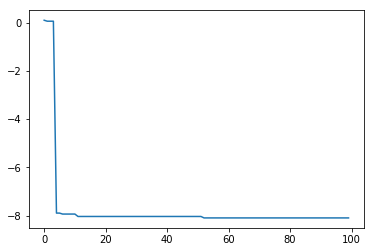

In [8]:
c_energies = []
for _ in range(100):
    c_energies.append(c_model.energy)
    c_model.update()
    c_model.beta /= 0.9
plt.plot(c_energies)

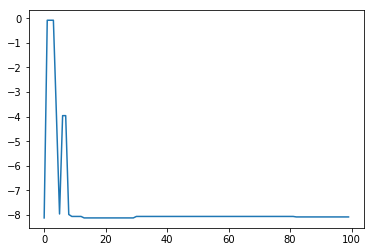

In [9]:
q_energies = []
for _ in range(100):
    q_energies.append(q_model.classical_energy)
    q_model.update()
    q_model.beta /= 0.9
    q_model.gamma *= 0.9
plt.plot(q_energies)

In [10]:
class Annealer(metaclass=abc.ABCMeta):
    def __init__(self, model):
        self.model = model
        
    def anneal(self, **kwargs):
        return self.optimize(**kwargs)
    
    def optimize(self, max_iter=1000, iter_callback=None, **kwargs):
        self.setup()
        for _ in range(max_iter):
            if self.is_frozen():
                break
            state_is_updated = self.model.update()
            self.update(state_is_updated)
            if iter_callback:
                iter_callback(self, state_is_updated)
        else:
            pass
        self.terminate()
        return self.model
        
    def setup(self):
        pass
    
    def terminate(self):
        pass
    
    @abc.abstractmethod
    def is_frozen(self):
        pass
    
    @abc.abstractmethod
    def update(self, state_is_updated):
        pass

In [11]:
class SimulatedAnnealer(Annealer):
    def __init__(self, model, beta_factor=0.95, freeze_limit=10):
        super().__init__( model)
        
        self.beta_factor = beta_factor
        self.freeze_limit = freeze_limit
        self.freeze_count = 0
        self.min_energy = self.model.energy
        
    def is_frozen(self):
        return self.freeze_count >= self.freeze_limit
    
    def update(self, state_is_updated):
        energy = self.model.energy
        if state_is_updated and energy < self.min_energy:
            self.min_energy = energy
            self.freeze_count = 0
        else:
            self.freeze_count += 1
            
        self.model.beta /= self.beta_factor

In [12]:
class QuantumAnnealer(Annealer):
    def __init__(self, model, beta_factor=0.95, gamma_factor=0.9, freeze_limit=10):
        super().__init__( model)
        
        self.beta_factor = beta_factor
        self.gamma_factor = gamma_factor
        self.freeze_limit = freeze_limit
        self.freeze_count = 0
        self.min_energy = self.model.energy
        
    def is_frozen(self):
        return self.freeze_count >= self.freeze_limit
    
    def update(self, state_is_updated):
        energy = self.model.energy
        if state_is_updated and energy < self.min_energy:
            self.min_energy = energy
            self.freeze_count = 0
        else:
            self.freeze_count += 1
            
        self.model.beta /= self.beta_factor
        self.model.gamma *= self.gamma_factor

In [13]:
c_annealer = SimulatedAnnealer(c_model)

In [14]:
c_annealer.anneal()
print(c_annealer.is_frozen())
print(c_annealer.model.energy)
print(c_annealer.model.state)

True
-8.1
[[ 1 -1  1]
 [-1  1 -1]
 [-1 -1 -1]]


In [15]:
q_annealer = QuantumAnnealer(q_model)

In [16]:
q_annealer.anneal()
print(q_annealer.is_frozen())
print(q_annealer.model.classical_energy)
print(q_annealer.model.classical_state)

True
-8.08
[[ 1 -1  1]
 [ 1 -1 -1]
 [ 1 -1 -1]]


## Travelling Salesman Problem

|変数|内容|
|:--:|:---|
|ハミルトニアン| $
\frac{1}{4}\Sigma_{i, a, b}D_{ab}\sigma_{i,a}\sigma_{i+1, b}
+ F\Sigma_{i, j, a}\sigma_{i, a}\sigma_{j, a}
+ G\Sigma_{i, a, b}\sigma_{i, a}\sigma_{i, b}
+\frac{1}{2}\Sigma_{i, a, b}D_{a, b}\sigma_{i, a}
+(N-2)F\Sigma_{i, a}\sigma_{i, a}
+(N-2)G\Sigma_{i, a}\sigma_{i, a}
$|
||$
\Sigma_{t,a \neq b}d_{a,b}\sigma_{t, a}\sigma_{t+1, b}
+F\Sigma_{a, t, u}\sigma_{t,a}\sigma_{u,a}
+F\Sigma_{t, a, b}\sigma_{t,a}\sigma_{t,b}
+2\Sigma_{t,a\neq b}d_{a,b}\sigma_{t,a}
+4(N-2)F\Sigma_{a,t}\sigma_{t, a}
$|
|lattice_shape| #city x #city (time, place)|
|$D_{a, b}$| ab 間の距離|
|F| 時間方向の制約の強さ|
|G|場所方向の制約の強さ|

物理マシンを想定していると

- 制約条件を如何に取り扱うかが難しい
  - 勝手な近傍を選べない
- Jを予め決めておかなければならない
  - Jの形も、マシンによって制約が違うはず
- T/Gammaのスケジューリングは??

In [184]:
def load_data(tsp_filename):
    positions = []
    city_ids = []
    with open(tsp_filename) as input_:
        for l in input_:
            if l.strip() == 'NODE_COORD_SECTION':
                break
        for l in input_:
            if l.strip() == 'EOF':
                break
            row = l.strip().split(' ')
            city_id = row[0]
            x = float(row[1])
            y = float(row[2])
            positions.append((x, y))
            city_ids.append(city_id)
    return positions, city_ids

def distance(pos1, pos2):
    x = pos1[0] - pos2[0]
    y = pos1[1] - pos2[1]
    return math.sqrt(x**2 + y**2)

def build_j(positions, f=1000.0):
    j = collections.defaultdict(float)
    n = len(positions)
    for t in range(n):
        for id1, pos1 in enumerate(positions):
            for id2, pos2 in enumerate(positions):
                if id1 != id2:
                    j[t, id1, (t+1)%n, id2] = distance(pos1, pos2)
    
    for  t in range(n):
        for a in range(n):
            for b in range(n):
                    j[t, a, t, b] += f
                    
    for t in range(n):
        for u in range(n):
            for a in range(n):
                j[t, a, u, a] += f
                
    return j

def build_h(positions, f=1000.0):
    n = len(positions)
    h = np.zeros((n, n))
    
    for t in range(n):
        for a, pos1 in enumerate(positions):
            for b, pos2 in enumerate(positions):
                if a != b:
                    h[t, a] += 2*distance(pos1, pos2)
    
    for t in range(n):
        for a in range(n):
            h[t, a] += 4*(n-2)*f
    
    return h

In [227]:
# cities = load_data('/Users/mitsuhisa.ohta/Desktop/ja9847.tsp')
positions, city_ids = load_data('/Users/mitsuhisa.ohta/Desktop/dj38.tsp')

In [284]:
j = build_j(positions, f=10000.)
# h = build_h(positions, f=10000.)
h = None
n = len(positions)
lattice_shape = (n, n)

In [285]:
model = IsingModel(j=j, h=h, lattice_shape=lattice_shape, neighbor_size=10)

In [299]:
annealer = SimulatedAnnealer(model, freeze_limit=100)

In [300]:
%%time
energy_history = []

def callback(annealer, state_is_updated):
    energy_history.append(annealer.model.energy)    

annealer.anneal(iter_callback=callback)

CPU times: user 1min 36s, sys: 179 ms, total: 1min 36s
Wall time: 1min 37s


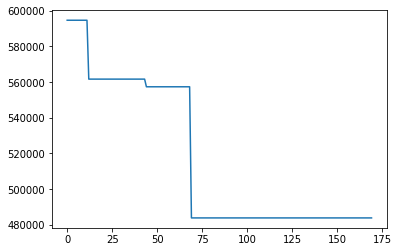

In [301]:
plt.plot(energy_history)

In [302]:
annealer.model.state + 1

array([[0, 0, 0, ..., 2, 0, 0],
       [0, 2, 2, ..., 2, 2, 0],
       [0, 0, 0, ..., 0, 0, 2],
       ..., 
       [0, 2, 2, ..., 0, 0, 0],
       [0, 0, 0, ..., 2, 2, 0],
       [2, 0, 2, ..., 2, 2, 2]])

In [304]:
(annealer.model.state + 1)[0]

array([0, 0, 0, 2, 2, 0, 2, 2, 2, 0, 0, 2, 0, 0, 2, 0, 2, 2, 2, 0, 2, 0, 0,
       2, 0, 2, 2, 2, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0])

In [311]:
q_model = QuantumIsingModel(j=j, h=h, lattice_shape=lattice_shape, n_trotter=5, neighbor_size=10)

In [312]:
q_annealer = QuantumAnnealer(q_model, freeze_limit=200)

In [329]:
%%time
# q_energy_history = []

def callback(annealer, state_is_updated):
    q_energy_history.append(annealer.model.classical_energy)    

q_annealer.anneal(iter_callback=callback)

CPU times: user 32min 4s, sys: 10.3 s, total: 32min 14s
Wall time: 32min 46s


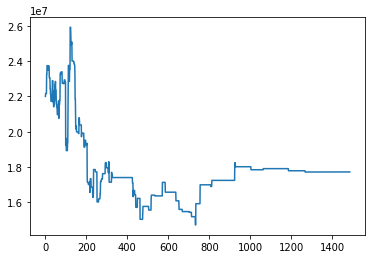

In [330]:
plt.plot(q_energy_history)

In [331]:
(annealer.model.state + 1)[1]

array([0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0,
       2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 0, 2, 2, 0])